### Importing Required Libraries 

In [1]:
import requests
import json, os, csv
from pathlib import Path
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!mkdir content
os.mkdir("content/dsci_project")

## Open Library URL with search query asterisk (*): resulting into all the data of books and format for getting data into json format.

In [3]:
search_query = "*"
ol_base_url = "https://openlibrary.org"
format = ".json"

## Google API KEY and base url
### Google has a rate limiting of 1000 requests quota, We tried to increase the quota but didnt got any approval for google. So we fetched as much as possible with as much as data.

In [4]:
G_API_KEY = ""
G_BASE_URL = "https://www.googleapis.com/books/v1/volumes"


### Creating url for Google books API. 
#### Trying to be as generic (template driven) so we can use it later on.

In [5]:
search_url = f"{G_BASE_URL}?q={search_query}&maxResults=40&key={G_API_KEY}"
response = requests.get(search_url)
data = response.json()


### Creating empty lists to store data

In [6]:
get_ratings = []
books_data = []
rats = []

### ISBN and ratings is for Open Library API's.

In [7]:
isbn = "/isbn"
ratings = "/ratings"

### Calling Open Library API to get all the books data

In [8]:
ol_url = f"{ol_base_url}/search{format}?q={search_query}"
ol_response = requests.get(ol_url)

#### Dumping the data from Open Library as JSON format

In [9]:
if ol_response.status_code == 200:
    # Parse the JSON data
    ol_data = ol_response.json()

    # Save the data to a JSON file
    output_file_path = Path("content/dsci_project/book_dumps.json")

    # Check if the file already exists
    if output_file_path.is_file():
        print(f"The file '{output_file_path}' already exists.")
    else:
        with open(output_file_path, "w") as json_file:
            json.dump(ol_data, json_file)
            print(f"Data saved to '{output_file_path}'.")
else:
    # Print an error message if the request was not successful
    print(f"Error: {ol_response.status_code}")

Data saved to 'content\dsci_project\book_dumps.json'.


#### Assigning the file path as save by the above cell
#### Creating few empty lists for the further evaluations

In [10]:
file_path = Path("content/dsci_project/book_dumps.json")
ol_books = "/books/"
rating = "/ratings"
books = []
ratings_data = []
count = 0

### Here reading the data from file and calling the open library API for getting the details of the particular book and storing the json object into the books list object. 

In [11]:
if file_path.is_file():

    with open(file_path, "r") as json_file:
        books_data = json.load(json_file)
       
        print("Data read from the file:")
        for book in books_data["docs"]:
            for i in book["edition_key"]:
                #if count >= 10: # Comment this part for requesting full dataset
                    #break
                book_url = f"{ol_base_url}{ol_books}{i}{format}"
                
                book_response = requests.get(book_url)
                if book_response.status_code == 200:
                    book_data = book_response.json()
                    books.append(book_data)
                    count += 1
                    print(count, end=' ')
else:
    print(f"The file '{file_path}' does not exist.")

Data read from the file:
1 2 3 4 5 6 7 8 9 10 

##### Checking how many books data we got from the cell.

In [12]:
len(books)

10

##### Now Calling the Open Library API for ratings and storing into ratings_data list.

In [13]:
for i in books:
    works_key = i['works'][0]['key']
    # print(works_key)
    ratings = f"{ol_base_url}{works_key}{rating}{format}"
    get_rating = requests.get(ratings)
    if get_rating.status_code==200:
        get_rating_data = get_rating.json()
        ratings_data.append(get_rating_data)

##### Checking how many ratings we got compared to the books we have

In [14]:
len(ratings_data)

10

## Function: saving_data_from_ol

This function takes three parameters - `books`, `ratings_data`, and `csv_filename`. It is designed to save data from Open Library (OL) API responses to a CSV file. The CSV file includes information about books and their corresponding ratings.

### Parameters:
- `books`: A list containing book data obtained from Open Library API.
- `ratings_data`: A list containing ratings data obtained from Open Library API.
- `csv_filename`: The filename of the CSV file where the data will be saved.

### Logic:
1. The function opens the specified CSV file in write mode with UTF-8 encoding.
2. It creates a CSV writer object for writing data to the file.
3. The function writes the header row for type 1 data, including various attributes such as title, physical format, genre, etc.
4. It iterates through the provided `books` and `ratings_data` using the `zip` function.
5. For each book and its corresponding ratings summary, it extracts relevant information and writes it to the CSV file.
6. An empty row is written as a separator between entries.
7. The function prints a message indicating that the data has been successfully written to the specified CSV file.

**Note**: This function assumes a specific structure for the input data (`books` and `ratings_data`). Ensure that the input data conforms to the expected format for accurate CSV generation.


In [15]:
def saving_data_from_ol(books, ratings_data, csv_filename):
    with open(csv_filename, 'w', newline='', encoding='utf-8') as csvfile:
        # Create a CSV writer object
        csv_writer = csv.writer(csvfile)

        # Write header row for type 1 data
        header_type_1 = ['Title', 'Physical Format', 'Genre', 'Publishers', 'ISBN-10', 'Edition Name', 'ISBN-13', 'Publish Date', 'Average Rating', 'Count', 'Star Count']
        csv_writer.writerow(header_type_1)

        # Write data for type 1
        for book, summary in zip(books, ratings_data):
            summary_counts = [summary['counts']]
            csv_writer.writerow([
                book.get('title', ''),
                book.get('physical_format', ''),
                book.get('genres', []),
                ', '.join(book.get('publishers', [])),
                ', '.join(book.get('isbn_10', [])),
                book.get('edition_name', ''),
                ', '.join(book.get('isbn_13', [])),
                book.get('publish_date', ''),
                summary['summary']['average'],
                summary['summary']['count'],
                summary_counts
            ])

        # Write an empty row as a separator
        csv_writer.writerow([])

    print(f'Data written to {csv_filename}')

In [16]:
csv_filename = 'output_ol.csv'  
saving_data_from_ol(books, ratings_data, csv_filename)

Data written to output_ol.csv


## Function: fetch_books_data

This function retrieves book data from the Gutendex API within the specified range of book indices.

### Parameters:
- `start_index`: The starting index of the range for fetching book data.
- `end_index`: The ending index (exclusive) of the range for fetching book data.

### Returns:
- A list of dictionaries containing book data from Gutendex API within the specified range.

### Logic:
1. The function initializes an empty list, `gunt_books`, to store book data.
2. It iterates through the range of book indices from `start_index` to `end_index - 1`.
3. For each index, it constructs a URL to fetch book data from Gutendex API.
4. It sends a GET request to the constructed URL using the `requests.get` function.
5. If the response status code is 200 (OK), the JSON content of the response is extracted and appended to the `gunt_books` list.
6. The function prints the current index (for tracking progress) and continues to the next iteration.
7. Finally, the function returns the list of dictionaries containing book data.

**Note**: Ensure that the Gutendex API URL and response structure are compatible with the expected format for accurate book data retrieval.


In [17]:
def fetch_books_data(start_index,end_index):
    gunt_books = []
    for i in range(start_index,end_index):
        new_url = f"https://gutendex.com/books/{i}"
        req = requests.get(new_url)
        if req.status_code == 200:
            b = req.json()
            gunt_books.append(b)
            print(i,end=' ')
    return gunt_books

## Function: write_to_csv

This function writes data from a list of dictionaries (`gunt_books`) to a CSV file specified by the `csv_file_path`.

### Parameters:
- `gunt_books`: A list of dictionaries containing data to be written to the CSV file.
- `csv_file_path`: The path to the CSV file where the data will be written.

### Logic:
1. The function first checks if there is any data in the `gunt_books` list. If the list is empty, it prints a message indicating that there is no data to write, and the function returns without further action.
2. If there is data, the function extracts the header from the keys of the first dictionary in the list.
3. It opens the specified CSV file in write mode with newline='' to handle line endings correctly.
4. The function creates a `csv.DictWriter` object using the extracted header as fieldnames.
5. It writes the header row to the CSV file using the `writeheader` method.
6. The function iterates through the list of dictionaries (`gunt_books`) and writes each dictionary as a row in the CSV file using the `writerow` method.
7. After writing the data, the function prints a message indicating that the CSV file has been successfully created.

**Note**: Ensure that the data structure in `gunt_books` is consistent, and the CSV file is created with the expected headers and data.


In [18]:
def write_to_csv(gunt_books, csv_file_path):
    # Check if there is any data
    if not gunt_books:
        print("No data to write to CSV.")
        return
    
    # Extracting header from the first data item
    header = gunt_books[0].keys()

    # Writing to CSV
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=header)

        # Writing the header
        writer.writeheader()

        # Writing the data
        for row in gunt_books:
            writer.writerow(row)

    print(f"CSV file created: {csv_file_path}")

### Calling Fetch_books_data in segments so we dont have a data loss in between neither any API's response delayed causing failure avoiding rate limiting.

In [19]:
books_data_1 = fetch_books_data(0,7)


1 2 3 4 5 6 

In [20]:
books_data_2 = fetch_books_data(7,14)


7 8 9 10 11 12 13 

In [ ]:
books_data_3 = fetch_books_data(14000,21000)


In [ ]:
books_data_4 = fetch_books_data(21000,35000)


### Merging down the collected data into one list 

In [21]:
books_data_f = books_data_1 + books_data_2 #+ books_data_3 + books_data_4

### Using the write_to_csv function to create a csv file for further more cleaning and preprocessing of data.

In [22]:
csv_file_path = "guntenberg_books.csv"
write_to_csv(books_data_f, csv_file_path)

CSV file created: guntenberg_books.csv


In [23]:
#Krish processing code

In [24]:
df2 = pd.read_csv("processed1.csv")

In [25]:
df2['Author_Name'] = df2['Author_Name'].str.split(', ').apply(lambda x: ' '.join(reversed(x)))

In [26]:
df2['Description'] = "" 
df2['PageCount'] = "" 

In [27]:
count = 0
for i in zip(df2['title'],df2['Author_Name']):
    desc_url = f"{G_BASE_URL}{i[0].replace(' ', '%')}{i[1].replace(' ', '%')}&key={G_API_KEY}"
    desc_req = requests.get(desc_url)
    if desc_req.status_code ==200:
        desc = desc_req.json()
        try:
            description = desc['items'][0]['volumeInfo']['description']
            page_count = desc['items'][0]['volumeInfo']['pageCount']
        except KeyError as e:
            description = "N/A"
            page_count = "N/A"
        df2.loc[(df2['title'] == i[0]) & (df2['Author_Name'] == i[1]), 'Description'] = description
        df2.loc[(df2['title'] == i[0]) & (df2['Author_Name'] == i[1]), 'PageCount'] = page_count
        count += 1
        print(count)
    
df2.to_csv('modified_file.csv', index=False)


KeyboardInterrupt: 

## Cleaning and Pre-processing of Datasets

### Open Library Dataset

In [28]:
import pandas as pd
pd.set_option('display.max_columns', None)

In [29]:
df_OL = pd.read_csv('output_ol.csv')

In [30]:
df_OL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            10 non-null     object 
 1   Physical Format  0 non-null      float64
 2   Genre            10 non-null     object 
 3   Publishers       10 non-null     object 
 4   ISBN-10          0 non-null      float64
 5   Edition Name     0 non-null      float64
 6   ISBN-13          0 non-null      float64
 7   Publish Date     10 non-null     int64  
 8   Average Rating   0 non-null      float64
 9   Count            10 non-null     int64  
 10  Star Count       10 non-null     object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1008.0+ bytes


In [31]:
df_OL.head()

,Title,Physical Format,Genre,Publishers,ISBN-10,Edition Name,ISBN-13,Publish Date,Average Rating,Count,Star Count
0,Nomination,NaN,[],U.S. Govt. Print. Off.,NaN,NaN,NaN,1979,NaN,0,"[{'1': 0, '2': 0, '3': 0, '4': 0, '5': 0}]"
1,Nomination,NaN,[],U.S. Govt. Print. Off.,NaN,NaN,NaN,1979,NaN,0,"[{'1': 0, '2': 0, '3': 0, '4': 0, '5': 0}]"
2,Nomination,NaN,[],U.S. Govt. Print. Off.,NaN,NaN,NaN,1979,NaN,0,"[{'1': 0, '2': 0, '3': 0, '4': 0, '5': 0}]"
3,Nomination,NaN,[],U.S. Govt. Print. Off.,NaN,NaN,NaN,1979,NaN,0,"[{'1': 0, '2': 0, '3': 0, '4': 0, '5': 0}]"
4,Nomination,NaN,[],U.S. Govt. Print. Off.,NaN,NaN,NaN,1979,NaN,0,"[{'1': 0, '2': 0, '3': 0, '4': 0, '5': 0}]"


In [32]:
df_OL.nunique()

Title              1
Physical Format    0
Genre              1
Publishers         1
ISBN-10            0
Edition Name       0
ISBN-13            0
Publish Date       1
Average Rating     0
Count              1
Star Count         1
dtype: int64

In [33]:
# Dropping all the duplicate data from the dataset

df_OL = df_OL.drop_duplicates(subset='Title', keep='first')

In [34]:
#Converting all the empty brackets to null values in column 'Genre'

df_OL['Genre'] = df_OL['Genre'].replace(r'^\s*\[\s*\]\s*$', pd.NA, regex=True)

In [35]:
# Cleaning the column Publishers as it was containing square brackets 

df_OL['Publishers'] = df_OL['Publishers'].str.replace('\\[', '', regex=True).str.strip()
df_OL['Publishers'] = df_OL['Publishers'].str.replace('\\]', '', regex=True).str.strip()

In [36]:
# Dropping all the null values from the column 'Publishers' and 'Publish Date'

df_OL = df_OL.dropna(subset=['Publishers'])
df_OL = df_OL.dropna(subset=['Publish Date'])

In [37]:
# Calculating Average Rating using the column 'Count'(Rating counts) and 'Ratings'(Rating given to a book)

df_OL = df_OL.drop('Average Rating', axis = 1)
df_OL['Star Count'] = df_OL['Star Count'].apply(lambda x: ast.literal_eval(x)[0] if pd.notna(x) else {})
df_OL['Average Rating'] = df_OL.apply(lambda row: sum(int(stars) * count for stars, count in row['Star Count'].items()) / row['Count'] if row['Count'] != 0 else 0, axis=1)

In [38]:
# Converting all the values of 'Publish Date' into same format using datetime

df_OL['Publish Date'] = pd.to_datetime(df_OL['Publish Date'], errors='coerce')
df_OL['Published Year'] = df_OL['Publish Date'].dt.year

### Gutenberg Dataset

In [39]:
df_GUT = pd.read_csv('guntenberg_books.csv')

In [40]:
df_GUT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              13 non-null     int64 
 1   title           13 non-null     object
 2   authors         13 non-null     object
 3   translators     13 non-null     object
 4   subjects        13 non-null     object
 5   bookshelves     13 non-null     object
 6   languages       13 non-null     object
 7   copyright       13 non-null     bool  
 8   media_type      13 non-null     object
 9   formats         13 non-null     object
 10  download_count  13 non-null     int64 
dtypes: bool(1), int64(2), object(8)
memory usage: 1.2+ KB


In [41]:
df_GUT.head()

,id,title,authors,translators,subjects,bookshelves,languages,copyright,media_type,formats,download_count
0,1,The Declaration of Independence of the United ...,"[{'name': 'Jefferson, Thomas', 'birth_year': 1...",[],"['United States -- History -- Revolution, 1775...","['American Revolutionary War', 'Politics', 'Un...",['en'],False,Text,{'text/html': 'https://www.gutenberg.org/ebook...,2489
1,2,The United States Bill of Rights: The Ten Orig...,"[{'name': 'United States', 'birth_year': None,...",[],"['Civil rights -- United States -- Sources', '...","['American Revolutionary War', 'Politics', 'Un...",['en'],False,Text,{'text/html': 'https://www.gutenberg.org/ebook...,2627
2,3,John F. Kennedy's Inaugural Address,"[{'name': 'Kennedy, John F. (John Fitzgerald)'...",[],['Presidents -- United States -- Inaugural add...,[],['en'],False,Text,{'text/html': 'https://www.gutenberg.org/ebook...,935
3,4,Lincoln's Gettysburg Address: Given November 1...,"[{'name': 'Lincoln, Abraham', 'birth_year': 18...",[],['Consecration of cemeteries -- Pennsylvania -...,['US Civil War'],['en'],False,Text,{'text/html': 'https://www.gutenberg.org/ebook...,1191
4,5,The United States Constitution,"[{'name': 'United States', 'birth_year': None,...",[],['United States -- Politics and government -- ...,"['American Revolutionary War', 'Politics', 'Un...",['en'],False,Text,{'text/html': 'https://www.gutenberg.org/ebook...,931


In [42]:
df_GUT.nunique()

id                13
title             13
authors            7
translators        1
subjects          11
bookshelves        8
languages          1
copyright          1
media_type         1
formats           13
download_count    13
dtype: int64

In [43]:
# Dropping unneccessary column 'formats'

df_GUT.drop(['formats'],axis=1,inplace=True)

In [44]:
# Cleaning and processing the column language

df_GUT['languages'] = df_GUT['languages'].str.strip("[]").str.replace("'", "")
print(df_GUT['languages'].unique())

['en']


In [45]:
# Cleaning and processing the column language


language_mapping = {
    'fi': 'Finnish',
    'eo': 'Esperanto',
    'nl': 'Dutch',
    'pt': 'Portuguese',
    'it': 'Italian',
    'de': 'German',
    'es': 'Spanish',
    'sv': 'Swedish',
    'no': 'Norwegian',
    'hu': 'Hungarian',
    'tl': 'Tagalog',
    'da': 'Danish',
    'zh': 'Chinese',
    'fur': 'Friulian',
    'fy': 'Frisian',
    'is': 'Icelandic',
    'cy': 'Welsh',
    'af': 'Afrikaans',
    'el': 'Greek',
    'ca': 'Catalan',
    'ilo': 'Iloko',
    'te': 'Telugu',
    'oj': 'Ojibwe',
    'br': 'Breton',
    'ga': 'Irish',
    'gl': 'Galician',
    'pl': 'Polish',
    'nah': 'Nahuatl',
    'ale': 'Aleut',
    'nap': 'Neapolitan',
    'oc': 'Occitan',
    'he': 'Hebrew',
    'iu': 'Inuktitut',
    'ja': 'Japanese',
    'ceb': 'Cebuano',
    'gla': 'Scottish Gaelic',
    'yi': 'Yiddish',
    'sr': 'Serbian',
    'mi': 'Maori',
    'csb': 'Kashubian',
    'enm': 'Middle English',
    'bg': 'Bulgarian',
    'et': 'Estonian',
    'ru': 'Russian',
    'ar': 'Arabic',
    'ro': 'Romanian',
    'sl': 'Slovenian',
    'fa': 'Persian',
    'ko': 'Korean',
    'en': 'English',
    'myn': 'Mayan',
    'oji': 'Ojibwa',
    'nai': 'North American Indian',
    'cs': 'Czech',
    'nav': 'North Ndebele',
    'bgs': 'Bulgarian',
    'kld': 'Lydenberg',
    'brx': 'Bodo',
    'grc': 'Greek Ancient',
    'ia': 'Native Interlingua',
    'ang': 'English, Old (ca.450-1100)'
}

# Applying the conversion directly to the 'language' column
df_GUT['languages'] = df_GUT['languages'].apply(lambda x: ', '.join([language_mapping.get(lang, lang) for lang in x.split(', ')]))

In [46]:
#Cleaning the column 'authors' as it contains 'author name', 'author birth year' and 'author death year'

import ast

df_GUT['authors'] = df_GUT['authors'].apply(ast.literal_eval)
df_GUT[['Author_Name', 'Author_Birth_year', 'Author_Death_year']] = df_GUT['authors'].apply(lambda x: pd.Series([
    x[0]['name'] if x and x[0].get('name') else None,
    x[0].get('birth_year') if x and x[0].get('birth_year') else None,
    x[0].get('death_year') if x and x[0].get('death_year') else None
]))
df_GUT = df_GUT.drop('authors', axis=1)

In [47]:
#Dropping null values from column 'Author_Name'

df_GUT.dropna(subset=['Author_Name'], inplace=True)

In [48]:
# Cleaning the column 'subjects'

df_GUT['subjects'] = df_GUT['subjects'].apply(eval)
df_GUT['subjects'] = df_GUT['subjects'].apply(lambda x: [item.split('--')[0].strip() for item in x])

## Data Analysis of Datasets

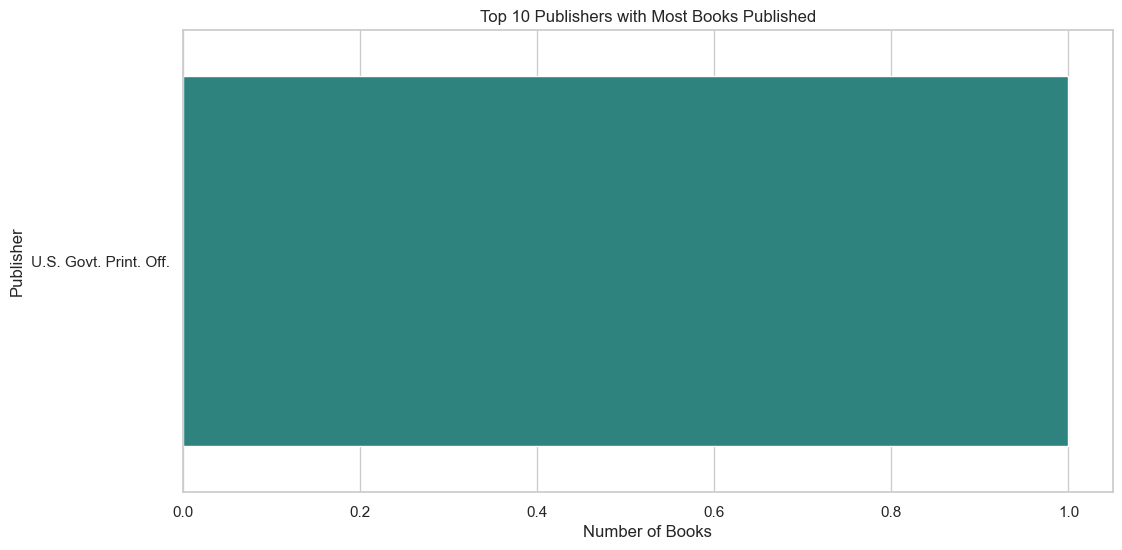

In [49]:
publisher_counts = df_OL['Publishers'].value_counts()
top_publishers = publisher_counts.head(10)
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.barplot(x=top_publishers.values, y=top_publishers.index, palette='viridis')
plt.title('Top 10 Publishers with Most Books Published')
plt.xlabel('Number of Books')
plt.ylabel('Publisher')

# Show the plot
plt.show()

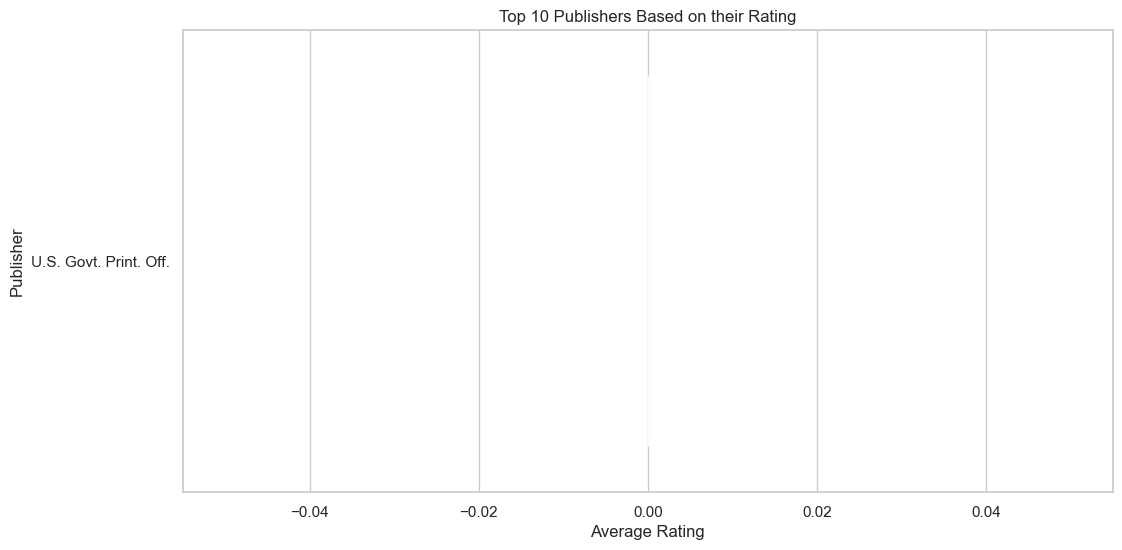

In [50]:
publisher_ratings = df_OL.groupby('Publishers')['Average Rating'].mean().reset_index()
publisher_ratings_sorted = publisher_ratings.sort_values(by='Average Rating', ascending=False)
top_10_publishers = publisher_ratings_sorted.head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='Average Rating', y='Publishers', data=top_10_publishers, palette='viridis')
plt.title('Top 10 Publishers Based on their Rating')
plt.xlabel('Average Rating')
plt.ylabel('Publisher')
plt.show()

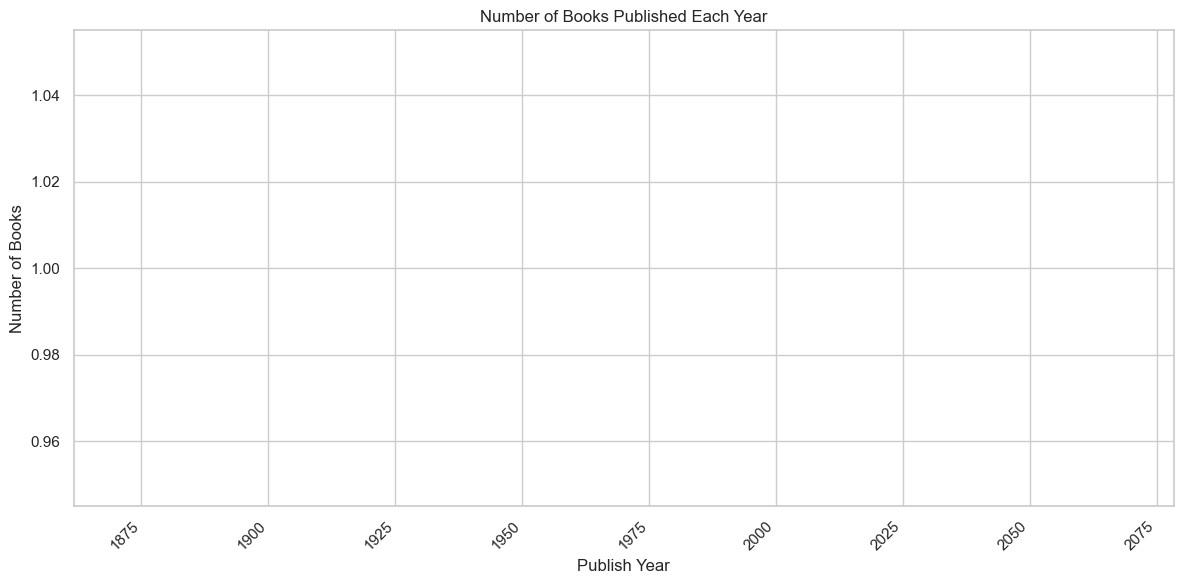

In [51]:
yearly_counts = df_OL['Published Year'].value_counts().sort_index()

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(x=yearly_counts.index, y=yearly_counts.values, color='purple')

plt.title('Number of Books Published Each Year')
plt.xlabel('Publish Year')
plt.ylabel('Number of Books')
plt.xticks(rotation=45, ha='right')  # Tidy x-axis with rotated labels
plt.tight_layout()
plt.show()

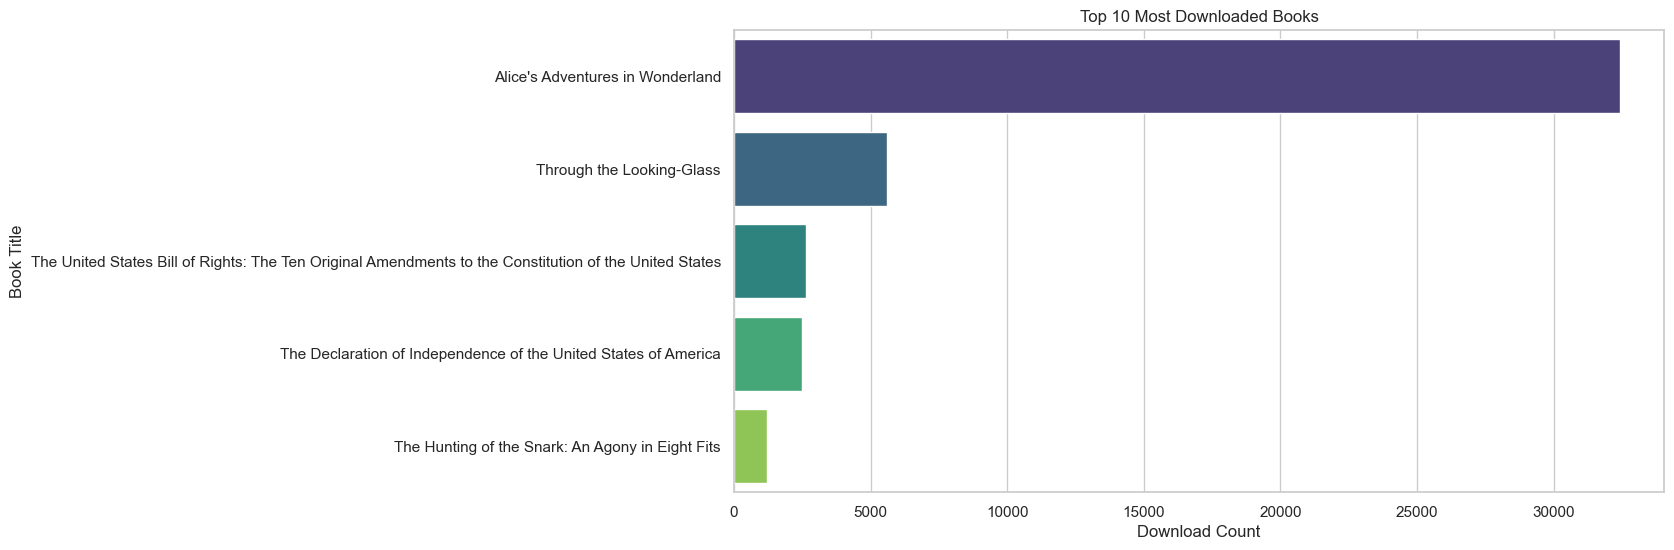

In [52]:
df_GUT = df_GUT.sort_values(by='download_count', ascending=False)
top_downloaded_books = df_GUT.head(5)
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.barplot(x='download_count', y='title', data=top_downloaded_books, palette='viridis')
plt.title('Top 10 Most Downloaded Books')
plt.xlabel('Download Count')
plt.ylabel('Book Title')
plt.show()

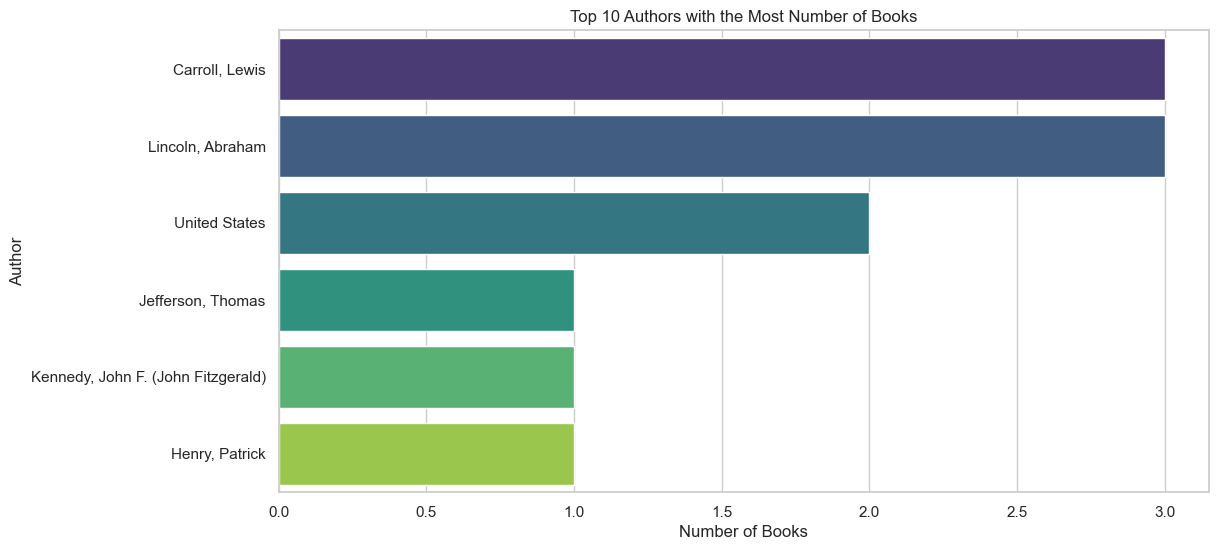

In [53]:
df_filtered = df_GUT[~df_GUT['Author_Name'].isin(['Various', 'Anonymous'])]
author_counts = df_filtered['Author_Name'].value_counts()
top_authors = author_counts.head(10)

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(x=top_authors.values, y=top_authors.index, palette='viridis')
plt.title('Top 10 Authors with the Most Number of Books')
plt.xlabel('Number of Books')
plt.ylabel('Author')
plt.show()

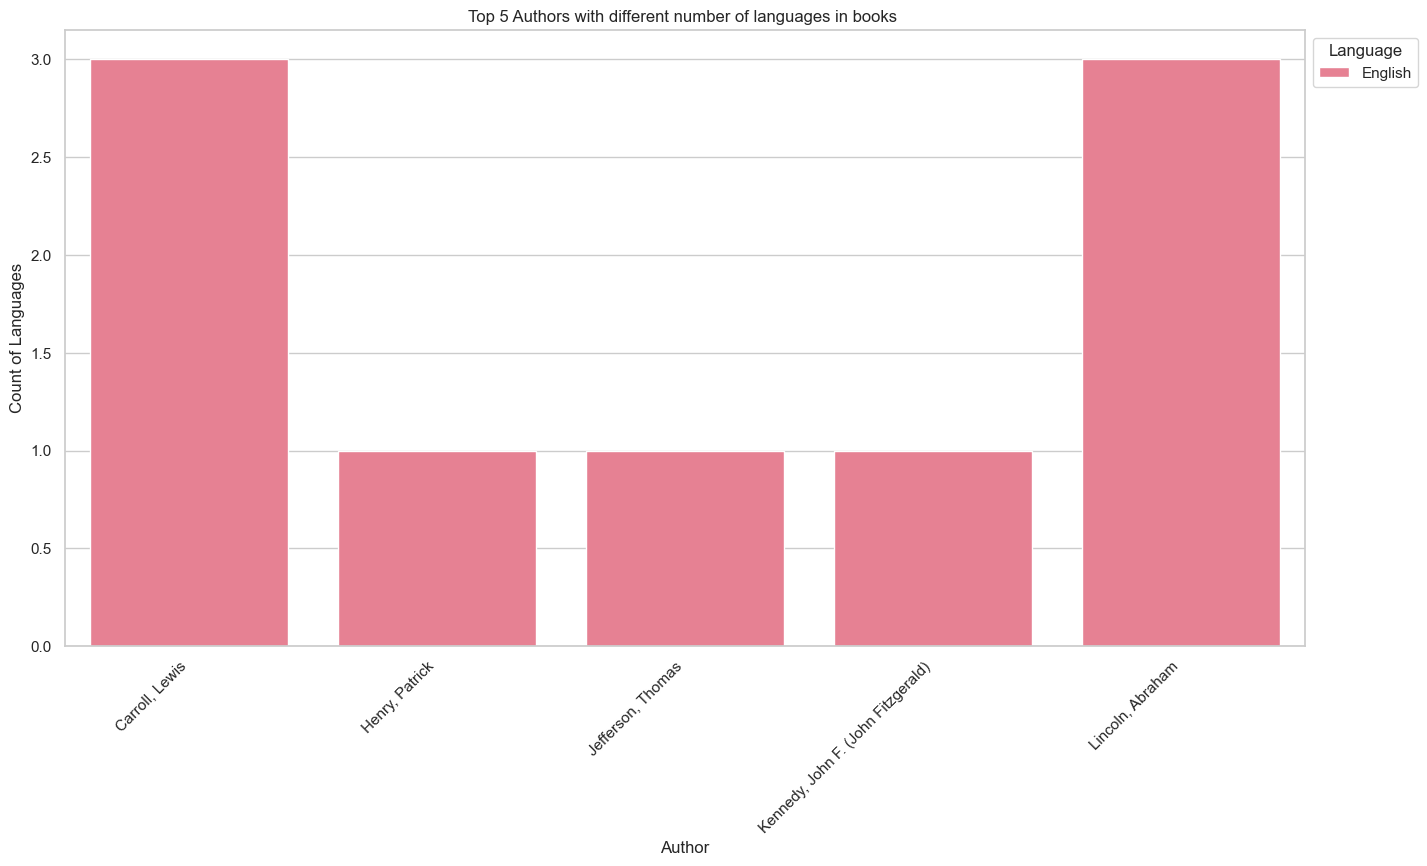

In [54]:
df_filtered = df_GUT[~df_GUT['Author_Name'].isin(['Various', 'Anonymous'])]

top_authors = df_filtered.groupby('Author_Name')['languages'].nunique().nlargest(5).index
df_top5 = df_filtered[df_filtered['Author_Name'].isin(top_authors)]
sns.set(style="whitegrid")
custom_palette = sns.color_palette("husl", len(top_authors))
plt.figure(figsize=(16, 8))
sns.countplot(x='Author_Name', hue='languages', data=df_top5, palette=custom_palette, order=top_authors)

plt.title('Top 5 Authors with different number of languages in books ')
plt.xlabel('Author')
plt.ylabel('Count of Languages')
plt.legend(title='Language', bbox_to_anchor=(1, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.show()

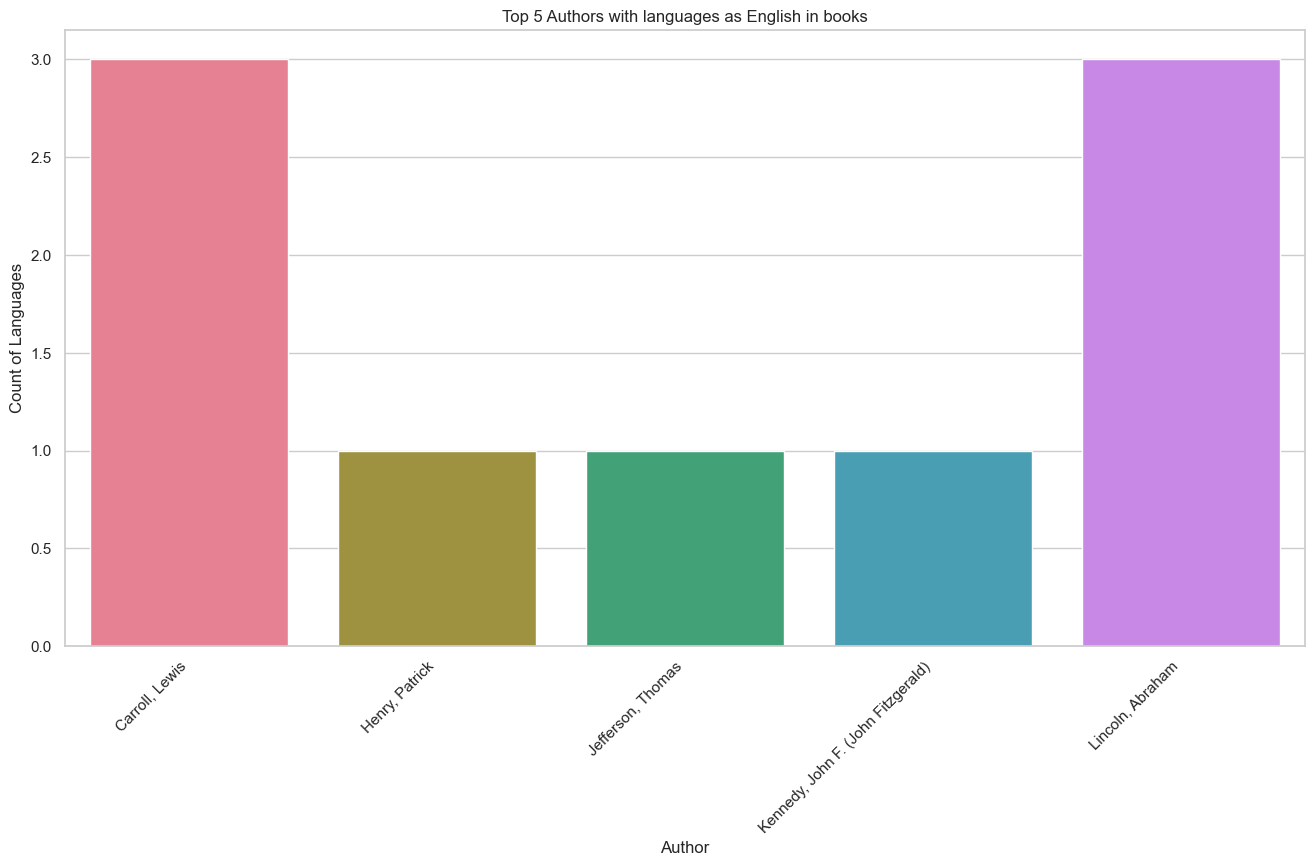

In [55]:
df_filtered = df_GUT[~df_GUT['Author_Name'].isin(['Various', 'Anonymous'])]
top_authors = df_filtered.groupby('Author_Name')['languages'].nunique().nlargest(5).index
df_top5_english = df_filtered[(df_filtered['Author_Name'].isin(top_authors)) & (df_filtered['languages'] == 'English')]

sns.set(style="whitegrid")
custom_palette = sns.color_palette("husl", len(top_authors))
plt.figure(figsize=(16, 8))
sns.countplot(x='Author_Name', data=df_top5_english, palette=custom_palette, order=top_authors)

plt.title('Top 5 Authors with languages as English in books')
plt.xlabel('Author')
plt.ylabel('Count of Languages')
plt.xticks(rotation=45, ha='right')
plt.show()

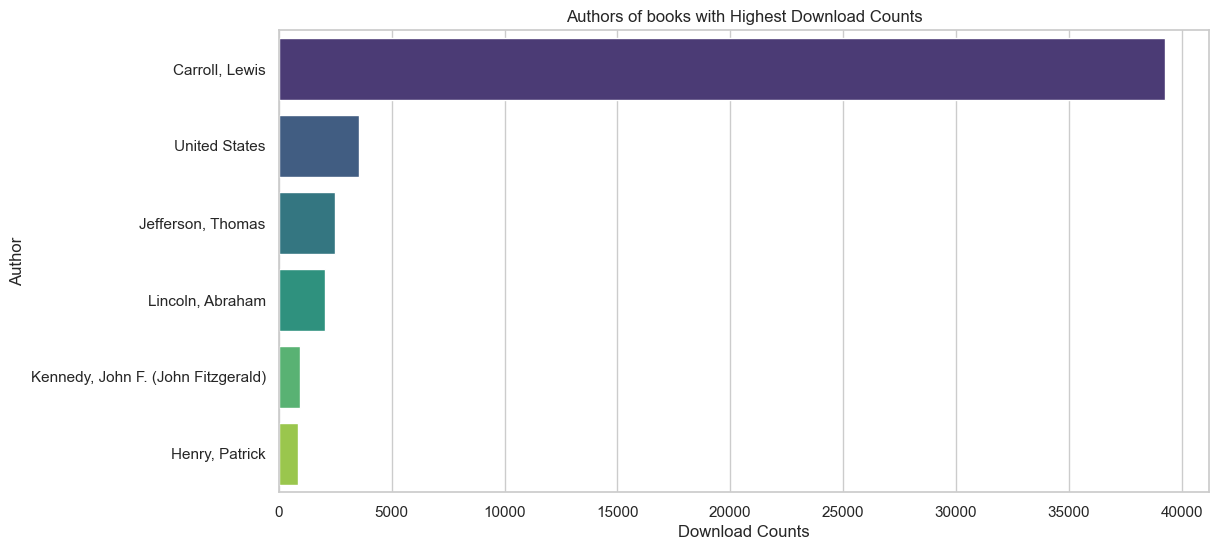

In [56]:
df_filtered = df_GUT[~df_GUT['Author_Name'].isin(['Various', 'Anonymous'])]
author_counts = df_filtered.groupby('Author_Name')['download_count'].sum().reset_index()
author_counts_sorted = author_counts.sort_values(by='download_count', ascending=False)
top_10_authors = author_counts_sorted.head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='download_count', y='Author_Name', data=top_10_authors, palette='viridis')
plt.title('Authors of books with Highest Download Counts')
plt.xlabel('Download Counts')
plt.ylabel('Author')
plt.show()